In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

# imports handling data and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# standard paramenters
batch_size = 8
image_height = 500
image_width = 500

train_path = '/content/drive/MyDrive/D7047E_project/chest_xray/train'
test_path = '/content/drive/MyDrive/D7047E_project/chest_xray/test'
val_path = '/content/drive/MyDrive/D7047E_project/chest_xray/val'

# Pnuemonia detection with ResNet50 with transfer learning
Refs:<br>
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7598372/


## Importing dataset

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


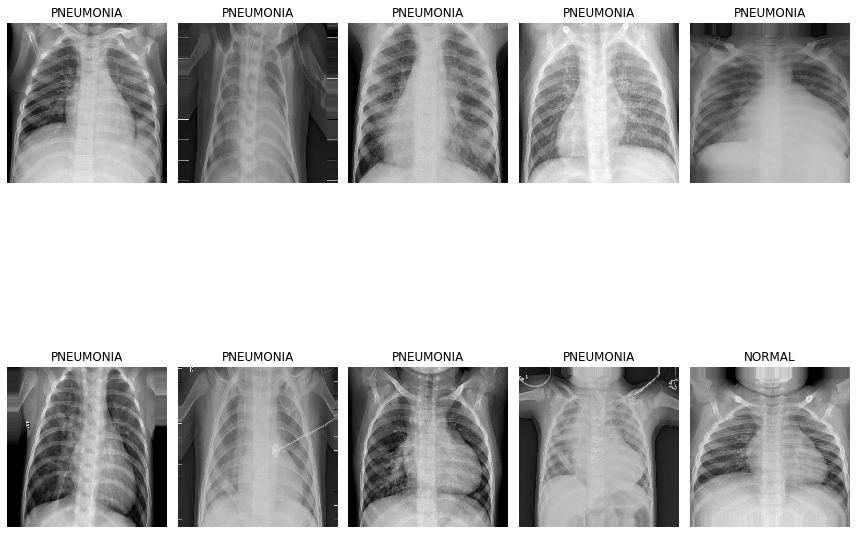

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image data generator for trian set
image_gen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
)

# Image data generator for test/validation set
test_data_gen = ImageDataGenerator(rescale=1./255)

train = image_gen.flow_from_directory(
    train_path,
    target_size=(image_height, image_width),
    color_mode='rgb',
    class_mode='binary',
    batch_size=batch_size
)

test = test_data_gen.flow_from_directory(
    test_path,
    target_size=(image_height, image_width),
    color_mode='rgb',
    shuffle=False,
    class_mode='binary',
    batch_size=batch_size
)

validation = test_data_gen.flow_from_directory(
    val_path,
    target_size=(image_height, image_width),
    color_mode='rgb',
    class_mode='binary',
    batch_size=batch_size
)

plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

## Metrics

In [ ]:
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Pretrained ResNet50
Experiment with ResNet50 pretrained on ImageNet dataset using feature extraction as the transfer learning method.

In [ ]:
from tensorflow.keras.layers import Input, AveragePooling2D, Flatten, Dense, Dropout

# create a model to include the ResNet50 as block
def model_resnet(input_shape, name, pretrained=False):

  if pretrained:
    weights="imagenet"
  else:
    weights=None

  # pretrained ressnet101 block
  resnet_block = tf.keras.applications.ResNet50(
      include_top=False,
      weights=weights,
      input_tensor=Input(shape=input_shape),
      pooling='avg'
  )

  # freeze the parameters of resnet101
  for layer in resnet_block.layers[: -10]:
    layer.trainable = False

  headmodel = resnet_block.output
  headmodel = Flatten(name='flatten') (headmodel)
  headmodel = Dense(256, activation='relu') (headmodel)
  headmodel = Dropout(0.4) (headmodel)
  headmodel = Dense(128, activation='relu') (headmodel)
  headmodel = Dropout(0.4) (headmodel)
  headmodel = Dense(64 , activation='relu') (headmodel)
  headmodel = Dropout(0.4) (headmodel)
  headmodel = Dense(1, activation='softmax') (headmodel)
  
  model = tf.keras.models.Model(inputs=resnet_block.input, outputs=headmodel, name=name)

  return model

In [ ]:
# initiate resnet mode
input_shape = (500, 500, 3)
model = model_resnet(input_shape, 'model7_resnet50', pretrained=True)

# set hyperparameters and compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.binary_crossentropy,
    metrics=[f1, 'accuracy']
)

model.summary()

Model: "model7_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 500, 500, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 506, 506, 3)  0           input_19[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 250, 250, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 250, 250, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________

### Training
Training on pneumonia dataset.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint

# setting the paramenters for training
early = EarlyStopping(monitor='val_loss', mode='min', patience=10)
checkpointer = ModelCheckpoint(filepath = '/content/drive/MyDrive/D7047E_project/ResNet50_3/weights.hdfs', verbose = 1, save_best_only=True)
# learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.3, min_lr=0.000001)
callback_list = [early, checkpointer]

In [ ]:
# assigning class weights based on the distribution of the dataset
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(train.classes), train.classes)
cw = dict(zip(np.unique(train.classes), weights))
print(cw)

{0: 1.9448173005219984, 1: 0.6730322580645162}


In [ ]:
# train the model
with tf.device('/GPU:0'):
  history = model.fit_generator(
      train, steps_per_epoch= train.n//batch_size, 
      epochs = 25, validation_data= validation, 
      validation_steps= validation.n//batch_size, 
      callbacks=[checkpointer, early])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
652/652 [==============================] - 503s 772ms/step - loss: 0.5853 - f1: 0.8385 - accuracy: 0.7496 - val_loss: 1.0250 - val_f1: 0.5333 - val_accuracy: 0.3750

Epoch 00001: val_loss improved from inf to 1.02501, saving model to /content/drive/MyDrive/D7047E_project/ResNet50_3/weights.hdfs
INFO:tensorflow:Assets written to: /content/drive/MyDrive/D7047E_project/ResNet50_3/weights.hdfs/assets
Epoch 2/25
652/652 [==============================] - 334s 512ms/step - loss: 0.4467 - f1: 0.8374 - accuracy: 0.7488 - val_loss: 2.8947 - val_f1: 0.4000 - val_accuracy: 0.2500

Epoch 00002: val_loss did not improve from 1.02501
Epoch 3/25
652/652 [==============================] - 245s 376ms/step - loss: 0.3767 - f1: 0.8443 - accuracy: 0.7573 - val_loss: 0.5790 - val_f1: 0.7619 - val_accuracy: 0.6250

Epoch 00003: val_loss improved from 1.02501 to 0.57899, saving model to /content/drive/MyDrive/D7047E_project/ResNet50_3/weights.hdfs
INFO:tensorflow:Assets written to: /content/drive/

In [ ]:
# Saving the trained model
save_path = '/content/drive/MyDrive/D7047E_project/ResNet50_3/'
model.save(save_path+model.name)

# Saving history
np.save('/content/drive/MyDrive/D7047E_project/ResNet50_3/history_25_epochs.npy', history.history)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/D7047E_project/ResNet50_3/model7_resnet50/assets


### Evaluation

In [ ]:
history.history.keys()

dict_keys(['loss', 'f1', 'accuracy', 'val_loss', 'val_f1', 'val_accuracy'])

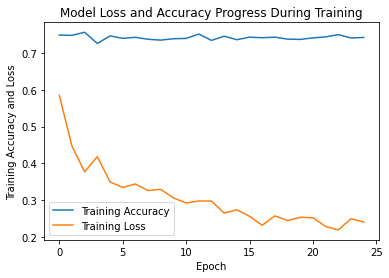

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

plt.title('Model Loss and Accuracy Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy and Loss')
plt.legend(['Training Accuracy', 'Training Loss'])

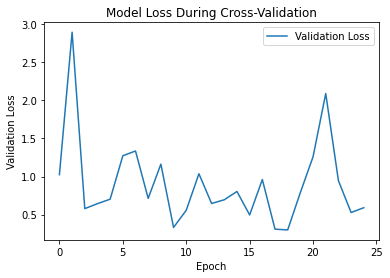

In [ ]:
plt.plot(history.history['val_loss'])
plt.title('Model Loss During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(['Validation Loss'])

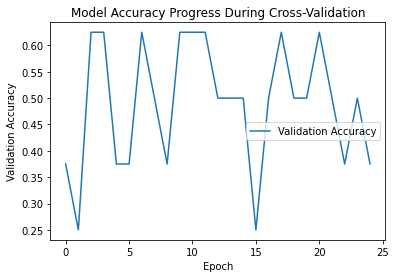

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Progress During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend(['Validation Accuracy'])

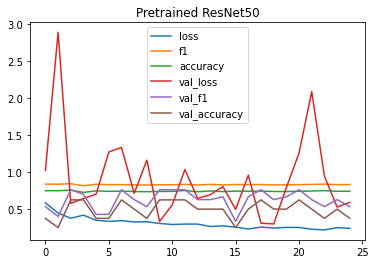

In [ ]:
pd.DataFrame(history.history).plot(title='Pretrained ResNet50')

In [ ]:
evaluate=model.evaluate_generator(test, verbose = 1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


156/156 [==============================] - 13s 82ms/step - loss: 0.5024 - f1: 0.6261 - accuracy: 0.6250


In [212]:
print('Accuracy during test: {}'.format(evaluate[1]))

Accuracy during test: 0.6260683536529541


In [233]:
preds = model.predict(test,verbose=1)

156/156 [==============================] - 13s 80ms/step


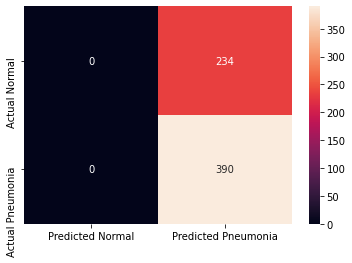

In [234]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [235]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00       234
   PNEUMONIA       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
